In [85]:
import requests, json, re, os
import xmltodict
import fastprogress
import zipfile
from pathlib import Path
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx

In [46]:
with open('ConfigIds for panelboard.txt', 'r') as f:
    configs = f.read().split('\n')

In [73]:
conf =  {"command":"reconfigurationTemplate",
         "modelName":"TYZ:PANELBOARD",
         "name":"GenGbl011922_0x43282961fpp53b6h",
         "userid":"ftqt08"}

header = {"key": "st_token",
          "value": "ST-8-iC2npNjIeOPBL1CLbu2U-compasd01",
          "type": "application/json"}

In [37]:
os.makedirs('jsons', exist_ok=True)
os.makedirs('jsons/filtered_jsons', exist_ok=True)

In [150]:
requests.post('https://q02.compasquality.siemens-info.com/mconfigserver/template', conf)

<Response [403]>

In [66]:
for cid in fastprogress.progress_bar(configs):
    conf['name'] = cid
    if f'{cid}.json' in os.listdir('jsons'): continue
    o = requests.post('https://q02.compasquality.siemens-info.com/mconfigserver/template', conf)
    if o.status_code == 200:
        o = json.dumps(xmltodict.parse(o.text))
        with open(f'jsons/{cid}.json', 'w') as f:
            f.write(o)

In [2]:
fs = list(map(lambda x: os.path.join('jsons', x), os.listdir('jsons')))

In [67]:
required_fields = ['isComplete', 'isConflicted',
         'isCopyable', 'isDeletable', 'instType', 'parent',
        'isPart', 'type', 'number', 'description', 'name']

filter_items = ()

for k, file in enumerate(fs):
    if os.path.isdir(file): continue
    with open(file, 'r') as f: o = json.load(f)
    acc_dict = []
    if o['IPC']['MODEL']['ELECTRICAL']['CREATED'] == None: continue
    for item in o['IPC']['MODEL']['ELECTRICAL']['CREATED']['INSTANCE']:
        d = dict()
        for r in required_fields:
            d[r] = item[f'@{r}']
        d['CSTIC'] = list(filter(lambda x: x['@isRequired'] == 'Y' or x['@number'] in filter_items, item['CSTIC']))
        acc_dict.append(d)
    json_out = json.dumps({'content': acc_dict})
    with open(f'jsons/filtered_jsons/{Path(file).name}', 'w') as out_file:
        out_file.write(json_out)

In [68]:
filtered_files = list(map(lambda x: os.path.join('jsons/filtered_jsons', x), os.listdir('jsons/filtered_jsons')))

In [69]:
with open(filtered_files[0], 'r') as f:
    o = json.load(f)

In [70]:
acc = []
for file in filtered_files:
    with open(file, 'r') as f: o = json.load(f)
    for item in o['content']:
        acc.append(' '.join(list(map(lambda x: x['@name'] + '_' + x['@value'], item['CSTIC']))))

In [23]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(acc)

<704x497 sparse matrix of type '<class 'numpy.float64'>'
	with 9314 stored elements in Compressed Sparse Row format>

In [122]:
set(list(filter(lambda x: x.endswith('.json'), os.listdir('jsons')))) - set(list(filter(lambda x: x.endswith('.json'), os.listdir('jsons/filtered_jsons'))))

{'HERMBR_0X74837E1338121F14.json',
 'HERMBR_0X7AE47E1338122728.json',
 'YOVARA_0X11727E122EB3BB1A.json',
 'ZACCTG1_0X12CA7E2C46113825.json',
 'ZACCTG1_0X13D97E2C46113A02.json',
 'ZAJTRX00C_0X40897E3214E1827C.json',
 'ZAJTRX00C_0X55C07E2811413B1F.json',
 'zvonjx1121719_0x22915841dsamghqv.json',
 'zvonjx1121719_0x64730421dsami0fr.json',
 'zvonjx1121719_0x78209341dsamh5kg.json'}

In [133]:
def process_json(file):
    with open(file, 'r') as f: o = json.load(f)
    dict_acc = dict()
    for item in o['content']:
        dict_acc[(item['parent'], item['number'])] = ' '.join(list(map(lambda x: x['@name'] + '_' + x['@value'], item['CSTIC'])))
    return dict_acc

In [147]:
process_json(filtered_files[0])

{('-1',
  '1'): 'A7J_DESCRIPTION_PANELBOARD\xa0P1 A7JPB_SYSTEM_VOLTAGE_208Y/120 3Ø 4W WYE AC A7JPB_SYSTEM_IR_65000.0 A7JPB_CERTIFICATION_UL A7JPB_PANEL_TYPE_P1 A7JPB_SERVICE_ENTRANCE_FALSE A7JPB_ENCLOSURE_TYPE_1 INDOOR A7JPB_BUS_MATERIAL_COPPER A7JPB_BUS_PLATING_TIN A7JPB_CAPACITY_100#perc; NEUTRAL A7JPB_GROUND_CONNECTOR_TRUE A7JPB_GND_CONN_OPTIONS_AL/CU A7JPB_GND_CONN_MOUNTING_SHIPPED W/ INTERIOR A7JPB_ADDITIONAL_GND_CONNECTOR_FALSE A7JPB_BRANCH_CONNECTOR_AL/CU A7JPB_SEISMIC_ZONE_NONE A7JPB_ENCLOSURE_PAINT_FALSE A7JPB_ENDWALL_WITH_KNOCKOUTS_FALSE A7JPB_ENCLOSURE_FRONT_STANDARD A7JPB_ENCLOSURE_LOCK_STANDARD A7JPB_TRIM_MOUNTING_SURFACE A7JPB_PNBD_LEAST_PANEL_TYPE_1.0 A7JPB_FRONT_GAGE_STANDARD A7J_DESIGNATION_EMC A7JPB_LIGHTING_PANEL_18 CIRCUITS A7JPB_DEFAULT_LIGHTING_PANEL_18 CIRCUITS A7JPB_FEED_TOP A7JPB_NAMEPLATE_LOCATION_TRIM A7JPB_PLANT_ROUTING_AUTO A7JPB_SEISMICALLY_QUALIFIED_FALSE A7JPB_BCM_FALSE',
 ('1',
  '2'): 'A7JPB_MAIN_AMPERE_125.0 A7J_IS_CUSTOM_FALSE A7JPB_SERVICE_ENTRANCE_

In [138]:
tfidf.transform(process_json(filtered_files[0]).values())

<4x497 sparse matrix of type '<class 'numpy.float64'>'
	with 74 stored elements in Compressed Sparse Row format>

In [139]:
G = nx.Graph()

In [140]:
G.add_nodes_from([x['number'] for x in o['content']])
G.add_edges_from(list(map(lambda x: (x['parent'], x['number']), o['content'])))

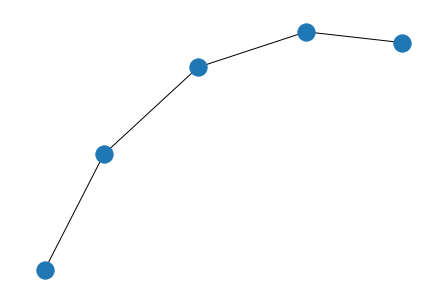

In [141]:
nx.draw(G)

In [145]:
nx.shortest_path(G, '-1', '3')

['-1', '1', '2', '3']

In [142]:
G.nodes

NodeView(('1', '2', '3', '4', '-1'))

In [143]:
G.edges

EdgeView([('1', '-1'), ('1', '2'), ('2', '3'), ('3', '4')])

In [121]:
list(G.neighbors(str(1)))

['-1', '2']

In [149]:
# o